# Computer Vision

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [3]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return train_loader, test_loader

In [4]:
train_loader, test_loader = load_dataloaders()
len(train_loader), len(test_loader) #количество батчей в train_loader и test_loader

Files already downloaded and verified
Files already downloaded and verified


(782, 157)

Визуализация датасет

In [5]:
def imshow(images, labels, padding_size=15, labels_split_size=25):
    # убрать нормализацию
    img = img / 2 + 0.5    
    npimg = img.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

            cat            plane            frog            ship


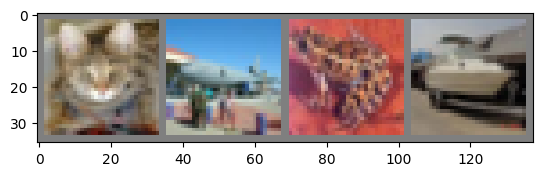

In [6]:
import sys
sys.path.append('../code-samples')
sys.path.append('./data')
from cv_utils import imshow

images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images[:4]), labels[:4], padding_size = 12, labels_split_size = 12)

Сверточная нейронная сеть, которуя будет обучать классифицировать изображения

In [7]:
import torch.nn as nn

class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_3 = nn.Conv2d(3, 32, 1)

        self.residual_block = nn.Sequential( 
            nn.Conv2d(3, 32, 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.BatchNorm2d(32)
        )

        self.clf = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):

        out = self.residual_block(x)
        out += self.conv_3(x)
        out = self.clf(out)

        return out

In [8]:
assert ResidualNet()(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Обучение сети

In [9]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)
        
        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):
        
        self.train_loss_log = [] 
        self.train_acc_log = [] 
        self.test_loss_log = []
        self.test_acc_log = []
        
        for epoch in range(n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")
    
    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

In [10]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

Сеть загружена на cpu
Epoch 0
 train loss: 92.36267846685541, train acc: 0.48399536445012786
 test loss: 79.23325969914721, test acc: 0.5558320063694268

Epoch 1
 train loss: 73.51008059362621, train acc: 0.5948889066496164
 test loss: 67.77289490183448, test acc: 0.6315684713375797

Epoch 2
 train loss: 65.34574719768047, train acc: 0.6420636189258312
 test loss: 63.803865815423855, test acc: 0.6491839171974523

Epoch 3
 train loss: 61.32321637609731, train acc: 0.6663403132992327
 test loss: 62.206652799229715, test acc: 0.6582404458598726

Epoch 4
 train loss: 58.66151233341383, train acc: 0.6804867327365729
 test loss: 62.15802625182328, test acc: 0.6598328025477707



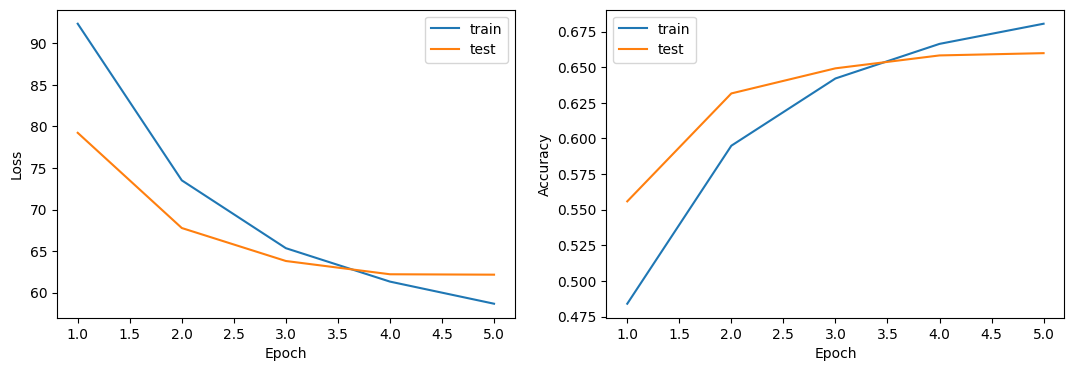

In [11]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

RN = ResidualNet()
optm = torch.optim.SGD(RN.parameters(), lr = 0.01, momentum = 0.9)
crit = nn.CrossEntropyLoss()

trains = Trainer(RN, optm, crit)
trains.train(train_loader, test_loader, 5)
plot_train_log(trains)

Аугментация изображений

In [12]:
transform_v2 = transforms.Compose(
        [
            transforms.AugMix(), #интерполирует между дополненными версиями изображения
            transforms.TrivialAugmentWide(), #преобразует изображение только один раз, используя случайное преобразование
            transforms.RandAugment(), #альтернативная версия AutoAugment(автоматически дополняет данные на основе заданной политики автодополнения)
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
)

Files already downloaded and verified
Files already downloaded and verified
            cat            plane            frog            ship


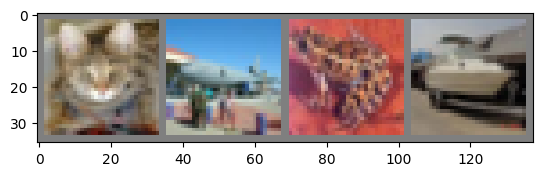

            truck            ship            horse            deer


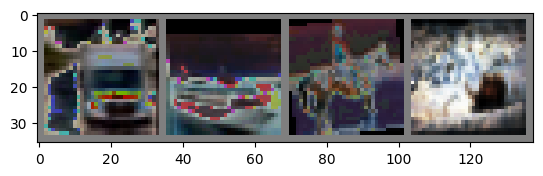

Сеть загружена на cpu
Epoch 0
 train loss: 56.399884862972954, train acc: 0.695871962915601
 test loss: 58.21692012981245, test acc: 0.6803343949044586

Epoch 1
 train loss: 55.062334782632114, train acc: 0.7020060741687979
 test loss: 54.813267045719606, test acc: 0.7045183121019108

Epoch 2
 train loss: 53.45875146504863, train acc: 0.7118965792838875
 test loss: 55.3917137194591, test acc: 0.7027269108280255

Epoch 3
 train loss: 52.22093036900396, train acc: 0.7188898657289002
 test loss: 56.94757519861695, test acc: 0.6906847133757962

Epoch 4
 train loss: 51.07082716949151, train acc: 0.7227861253196931
 test loss: 53.04821059961987, test acc: 0.7185509554140127



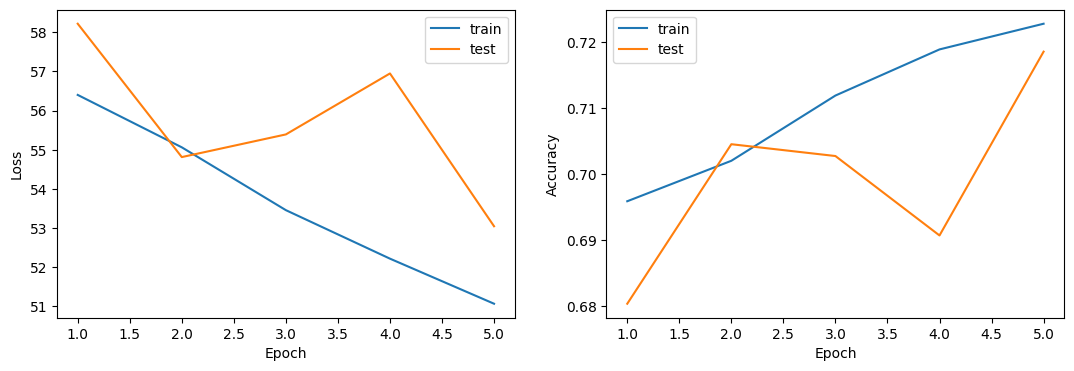

In [18]:
train_loader_2, test_loader_2 = load_dataloaders(transform_v2)
imshow(torchvision.utils.make_grid(images[:4]), (labels[:4]),padding_size = 12, labels_split_size = 12)
dataiter_2 = iter(test_loader_2)
images_2, labels_2 = next(dataiter_2)
imshow(torchvision.utils.make_grid(images_2[:4]), labels_2[:4], padding_size = 12, labels_split_size = 12)

trains = Trainer(RN, optm, crit)
trains.train(train_loader, test_loader, n_epochs = 5)
plot_train_log(trains)